Data de entrega: 31/07/2022
_________

Grupo:
- Ana Paula
- Maeba Tomaselli
- Nicolas

# Projeto módulo ML I ML II e MLIII - Crédito para Financiamento de Imóveis


____________


## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **bons pagadores** dos **maus pagadores**. 

Para isso, foi disponibilizada uma base de dados com milhares de casos de **empréstimos do passado** com diversas características dos clientes. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC** (mas isso é flexível, conforme detalhado mais abaixo!)


## Base de Dados

Serão utilizadas bases de dados com **informações cadastrais, histórico de crédito e balanços financeiros de diversos clientes**. 

O conjunto de dados está dividido em **treino e teste**, todos no formato csv. 

Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de **treino**, que contém o target (arquivo: `aplication_train.csv`)

Há uma base já pronta, mas as demais bases auxiliares também serão disponibilizadas (sintam-se à vontade para explorá-las e utilizar as informações que julgarem relevantes!)

[Clique aqui](https://drive.google.com/file/d/17fyteuN2MdGdbP5_Xq_sySN_yH91vTup/view) pra baixar os dados (eles estão disponiveis no arquivo zipado `credito-imoveis.zip`).

## Objetivo: para quem liberar o crédito?

### Classificar tipos de crédito

## Regras de Entrega

Deve ser entregue um arquivo csv com as **predições** para a base de teste.

Essa base deverá ser um Data Frame com duas colunas: a primeira sendo o **SK_ID_CURR** e a segunda a **probabilidade de inadimplência.**

### IMPORTANTE!

Entregar as predições com a **probabilidade da inadimplência ocorrer**, não a classe predita (pois eu irei calcular a AUC de teste, com os targets que eu tenho disponível ;D (mas depois vou compartilhar com vcs tbm!))

Além do arquivo com as predições, claro, entreguem também o notebook com o código utilizado. É importante que ele tenha:

- (i) a análise exploratória e construção das variáveis explicativas;

- (ii) a análise de modelagem, mostrando o processo das avaliações dos modelos e os motivos das decisões tomadas sobre qual modelo usar.

## Dicas


Explorar o conceito das variáveis: existe risco de imagem uma empresa utilizar variável de sexo para determinar risco de crédito? Vale a pena trazer a variável para o modelo?

Criar novas variáveis usando as variáveis que já estão na base: criatividade!

Qualquer dúvida, só me chamar! ;)


<br>

<br>

# Parte 1 - Exploração inicial dos dados

In [163]:
#Carregando bibliotecas de exploração
import pandas as pd
import numpy as np
from scipy import stats

#Carregando bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

#Carregando biblioteca de regularização
from sklearn.linear_model import Lasso

#Carregando bibliotecas para o preprocessamento dos dados
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.impute import SimpleImputer
#from sklearn.compose import ColumnTransformer

#Carregando bibliotecas de balanceamento de dados
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

#Carregando bibliotecas dos modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

#Carregando bibliotecas de avaliação dos modelos
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

<br>

## Carregando as bases de dados

In [164]:
def carrega_dataset(arquivo, index_col=None, encoding='UTF-8'):
    '''
    Função para carregar as tabelas e transformá-las em datasets
    
    args:
    - arquivo: nome do arquivo;
    - index_col: None se não for aplicável e 0 se transformar a primeira coluna em índice;
    - encoding: UTF-8 por padrão e codificação diferente quando necessário
    
    return:
    - df: dataset carregado
    '''

    #Dados para acessar o caminho do arquivo e usar a codificação
    path = 'datasets/dados_projeto'

    caminho_completo = '../' + path + '/' + arquivo

    df = pd.read_csv(caminho_completo, encoding=encoding, index_col=index_col)

    return df

In [165]:
#Nomes dos arquivos
application_train = 'application_train.csv'
home_credit_col = 'HomeCredit_columns_description.csv'

In [166]:
#Carregando os dados do application_train - tabela principal - treino
df_application_train = carrega_dataset(arquivo=application_train)

In [167]:
df_application_train.shape

(246008, 122)

<br>

# Limpeza e tratamento das colunas

## Criação da função com o pipeline para limpeza da base

Montaremos um pipeline para aplicar as transformações de forma organizada e replicável.

Passos a serem seguidos:<br>
1. Transformar a primeira coluna em index;<br>
2. Excluir colunas com mais de 40% dos dados faltantes;
3. Preencher dados numéricos com a média;
4. Preencher dados categóricos com o valor mais frequente;
5. Transformar as colunas categóricas em numéricas;<br>
    Conforme levantado na avaliação das colunas categóricas, transformar as colunas abaixo para numérica:
    - NAME_CONTRACT_TYPE - tipo de empréstimo - importante;
    - FLAG_OWN_CAR, FLAG_OWN_REALTY - se o cliente possui carro - importante, pode ser uma garantia;
    - NAME_INCOME_TYPE - tipo de renda do cliente - importante;
    - NAME_FAMILY_STATUS - status civil, pode ser importante;
    - NAME_HOUSING_TYPE - moradia atual, importante;
    - OCCUPATION_TYPE - tipo de ocupação profissional do cliente, importante;
    - ORGANIZATION_TYPE - tipo de organização onde o cliente trabalha, possivelmente manter;
    - FONDKAPREMONT_MODE?
    - HOUSETYPE_MODE?
    - EMERGENCYSTATE_MODE.

### Função que separa a base de treino e a base de teste:

In [168]:
def separa_treino_teste(df, col_target):
    
    '''
    Função para separar o dataset em treino e teste
    
    args:
    - df: dataset que será utilizado;
    - col_target: coluna que contém os resultados e será separada do dataset;
    
    return:
    - X_train: parte do dataset para treino sem a resposta (coluna target);
    - X_test: parte do dataset para teste sem a resposta (coluna target);
    - y_train: parte das linhas do dataset de treino com a resposta (coluna target);
    - y_test: parte das linhas do dataset de teste com a resposta (coluna target);
    '''
    
    # Separar a base de dados da resposta
    X = df.drop(labels=col_target, axis=1)
    y = df[col_target]

    # Dividir a base em treino e teste para evitar qualquer tipo de vazamento de dados
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    
    return X_train, X_test, y_train, y_test

### Criando as funções para excluir as colunas com dados faltantes:

In [169]:
def escolhe_col_mais_faltantes(df, limite_dados_faltantes):
    '''
    Função para selecionar as colunas que possuem mais de X(limite_dados_faltantes) 
    dados faltantes e monta um df com essas colunas

    args:
    - df: dataframe que será avaliado;
    - limite_dados_faltantes: porcentagem de dados faltantes a partir da qual a 
    coluna será excluída (ex: 40 = colunas com mais de 40% dos dados faltantes serão excluídas)

    return:
    - df_col_faltantes_X: dataframe contendo quais colunas serão excluídas
    '''

    # Ordenando os dados das colunas que mais possuem dados faltantes para as que menos possuem
    col_faltantes = df.isna().sum().sort_values(
        ascending=False) / df.shape[0] * 100

    # Porcentagem de dados faltantes acima da qual a coluna será excluída
    limite_dados_faltantes = limite_dados_faltantes

    # Seleção das colunas com mais de X(limite_dados_faltantes) dados faltantes
    lista_col_excluir = col_faltantes[col_faltantes > limite_dados_faltantes]

    # Tranformando em dataframe para que seja possível armazenar as colunas e as quantidades de dados faltantes
    df_col_faltantes_X = pd.DataFrame(lista_col_excluir)

    return df_col_faltantes_X

### Função para carregamento e limpeza da base

In [170]:
def pre_process_exclui_cols_dados_faltantes(arquivo, limite_dados_faltantes, index_col=None, encoding=None, excluir_cols=None):
    '''
        Função que faz o pré processamento dos dados:
        1. Carregamento do dataset e transformação da primeira coluna em index, quando necessário;
        2. Exclusão das colunas com mais de X% dos dados faltantes;
        3. Exclusão de colunas específicas escolhidas;
                
        args:
        - arquivo: nome do arquivo em csv que deverá ser carregado;
        - limite_dados_faltantes: porcentagem de dados faltantes que será usado como limite para exclusão de colunas;
        - index_col=None por padrão, ou pode indicar se alguma coluna será o índice (ex: 0);
        - encoding=None por padrão, ou pode indicar qual a codificação da base de dados (ex: Latin1);
        - excluir_cols: lista com o nome das colunas que deverão ser excluídas.
        
        return:
        - df com as colunas necessárias excluídas
    '''
    
    # Carregamento dos dados
    # ==========================================================
    df = carrega_dataset(arquivo=arquivo, index_col=index_col, encoding=encoding)
    
    
    # Excluir as colunas desnecessárias
    # ==========================================================
    #pipe_exclui_col_faltante = Pipeline([("exclui_col", exclui_col_dados_faltantes(df_col_faltantes_40.index.tolist()))])
    
    # Excluir as colunas avaliadas
    df.drop(excluir_cols, inplace=True, axis=1)
    
    # Excluir as colunas com mais de X% dos dados faltantes
    # Colunas que serão excluídas porque tem mais de X%(limite_dados_faltantes) dados faltantes
    df_col_exc = escolhe_col_mais_faltantes(df, limite_dados_faltantes)
    
    # df com as colunas com dados faltantes excluídas
    #df_semColFaltante = exclui_col_dados_faltantes(df, df_col_exc.index.tolist())
    df_semColFaltante = df.drop(columns=df_col_exc.index.tolist())
            
    return df_semColFaltante, df_col_exc

**MELHORIA DO CÓDIGO:** fazer uma função para selecionar apenas uma das colunas da correlação de forma automática.

### Exclusão das colunas

In [171]:
# Fazendo o pré processamento dos dados para aplicar os modelos - base principal de treino
# Limite de 40% de dados faltantes: mais do que 40% as colunas serão excluídas, pois
# teríamos mais dados adicionados do que dados reais
# Exclusão da coluna de gênero para evitar enviesamento do modelo
df, df_col_excluidas_dados_faltantes = pre_process_exclui_cols_dados_faltantes(application_train,
                                                                               40,
                                                                               index_col=0,
                                                                               encoding=None,
                                                                               excluir_cols=['CODE_GENDER'])

In [172]:
df.shape

(246008, 71)

In [173]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
456162,0,Cash loans,N,N,0,112500.0,700830.0,22738.5,585000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
134978,0,Cash loans,N,N,0,90000.0,375322.5,14422.5,324000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
318952,0,Cash loans,Y,N,0,180000.0,544491.0,16047.0,454500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
361264,0,Cash loans,N,Y,0,270000.0,814041.0,28971.0,679500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
260639,0,Cash loans,N,Y,0,144000.0,675000.0,21906.0,675000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [174]:
# Lista com as colunas excluídas que tinham muitos dados faltantes
col_excluidas_dados_faltantes = df_col_excluidas_dados_faltantes.index.tolist()

In [175]:
col_excluidas_dados_faltantes

['COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'OWN_CAR_AGE',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_AVG',
 'ELEVATORS_MODE',
 'ELEVATORS_MEDI',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'ENTRANCES_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'LIVINGAREA_AVG',
 'HOUSETYPE_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION

In [15]:
len(col_excluidas_dados_faltantes)

49

## Separação entre treino e teste - base sem as colunas com muitos dados faltantes

In [178]:
X_train, X_test, y_train, y_test = separa_treino_teste(df=df, col_target='TARGET')

In [179]:
X_train.shape

(172205, 70)

## Preenchimento das colunas

Para fazer o preenchimento das colunas, vamos usar as base separadas em treino e teste porque aplicaremos o preenchimento com a média nas colunas numéricas e a separação da base evitará vazamento de dados.

### Preenchimento das colunas categóricas

In [180]:
# Criando dataframe apenas com as variáveis categóricas para o treino e para o teste
X_train_cat = X_train.select_dtypes(exclude=np.number)
X_test_cat = X_test.select_dtypes(exclude=np.number)

# Preenchendo os dados faltantes das colunas categóricas com a palavra unknown
simpleImputer_cat = SimpleImputer(strategy='constant', fill_value='unknown')
simpleImputer_cat.fit(X_train_cat)
X_train_cat[:] = simpleImputer_cat.transform(X_train_cat)
X_test_cat[:] = simpleImputer_cat.transform(X_test_cat)

In [181]:
X_train_cat

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
SK_ID_CURR,,,,,,,,,,,
345657,Cash loans,N,Y,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,unknown,WEDNESDAY,XNA
409596,Cash loans,Y,Y,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,unknown,TUESDAY,Business Entity Type 3
446993,Cash loans,N,Y,Family,Working,Secondary / secondary special,Married,House / apartment,High skill tech staff,MONDAY,Business Entity Type 2
237441,Cash loans,N,Y,Unaccompanied,Working,Higher education,Civil marriage,House / apartment,Laborers,THURSDAY,Business Entity Type 3
148978,Cash loans,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,unknown,FRIDAY,Industry: type 3
...,...,...,...,...,...,...,...,...,...,...,...
394870,Cash loans,N,Y,"Spouse, partner",Commercial associate,Secondary / secondary special,Married,House / apartment,Accountants,SATURDAY,Construction
131720,Cash loans,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,SUNDAY,Other
409456,Cash loans,Y,Y,"Spouse, partner",Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Private service staff,THURSDAY,Self-employed


In [182]:
X_test_cat

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
SK_ID_CURR,,,,,,,,,,,
148054,Cash loans,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,unknown,MONDAY,XNA
127036,Cash loans,N,N,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Accountants,THURSDAY,Cleaning
353347,Cash loans,N,Y,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,unknown,THURSDAY,XNA
394518,Revolving loans,Y,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Managers,WEDNESDAY,Self-employed
203815,Cash loans,N,N,Unaccompanied,Pensioner,Higher education,Married,House / apartment,unknown,SATURDAY,XNA
...,...,...,...,...,...,...,...,...,...,...,...
362733,Cash loans,Y,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,With parents,Managers,SUNDAY,Business Entity Type 3
217169,Cash loans,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,unknown,TUESDAY,School
424025,Cash loans,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,THURSDAY,Other


### Preenchimento das colunas numéricas

In [183]:
# Preenchimento das colunas numéricas
X_train_num = preenche_numericas_media(X_train)

In [184]:
# Criando dataframe apenas com as variáveis numéricas para o treino e para o teste
X_train_num = X_train.select_dtypes(include=np.number)
X_test_num = X_test.select_dtypes(include=np.number)

# Preenchendo os dados faltantes das colunas numéricas com a média
simpleImputer_num = SimpleImputer(strategy="mean")
# Fazendo o fit somente no treino
simpleImputer_num.fit(X_train_num)
#Aplicando o fit do treino nos datasets de treino e teste
X_train_num[:] = simpleImputer_num.transform(X_train_num)
X_test_num[:] = simpleImputer_num.transform(X_test_num)

In [185]:
X_train_num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,0.0,40500.0,265851.0,11839.5,229500.0,0.031329,-21684.0,365243.0,-12509.0,-4789.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
409596,0.0,270000.0,900000.0,26446.5,900000.0,0.010643,-17693.0,-2678.0,-8797.0,-1226.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
446993,1.0,90000.0,112068.0,11047.5,99000.0,0.031329,-16691.0,-1291.0,-1392.0,-229.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
237441,0.0,202500.0,1125000.0,44743.5,1125000.0,0.028663,-21141.0,-2765.0,-6047.0,-4300.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
148978,2.0,117000.0,101880.0,10206.0,90000.0,0.016612,-14488.0,-3223.0,-2221.0,-2375.0,...,0.0,0.0,0.0,0.0,0.006592,0.006934,0.034443,0.265409,0.263899,1.902101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,2.0,180000.0,436032.0,34578.0,360000.0,0.046220,-11495.0,-2085.0,-5665.0,-3201.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000
131720,0.0,90000.0,299772.0,11430.0,247500.0,0.046220,-19980.0,-4469.0,-11464.0,-3503.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
409456,1.0,180000.0,269550.0,20988.0,225000.0,0.030755,-15977.0,-4260.0,-2527.0,-6106.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [186]:
X_test_num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
148054,0.0,45000.0,269550.0,12001.5,225000.0,0.011657,-10304.0,365243.0,-2264.0,-2259.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
127036,0.0,81000.0,128092.5,10399.5,103500.0,0.002134,-14881.0,-738.0,-661.0,-4434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
353347,0.0,207000.0,286704.0,12757.5,247500.0,0.018634,-21323.0,365243.0,-4221.0,-4471.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
394518,0.0,180000.0,180000.0,9000.0,180000.0,0.010966,-12173.0,-3123.0,-3666.0,-4774.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
203815,0.0,135000.0,675000.0,19737.0,675000.0,0.019101,-22970.0,365243.0,-3029.0,-1414.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362733,0.0,225000.0,269550.0,18364.5,225000.0,0.006305,-11575.0,-3402.0,-5695.0,-3951.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
217169,1.0,135000.0,348264.0,20124.0,315000.0,0.072508,-13996.0,-134.0,-8088.0,-1558.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
424025,2.0,76500.0,654498.0,27859.5,585000.0,0.010500,-13068.0,-565.0,-1122.0,-1532.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


#### União das bases de categóricas e numéricas para o treino e para o teste

In [187]:
# União das duas bases de treino
X_train = pd.concat([X_train_cat, X_train_num], axis=1)

In [188]:
X_train

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,Cash loans,N,Y,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,unknown,WEDNESDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
409596,Cash loans,Y,Y,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,unknown,TUESDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
446993,Cash loans,N,Y,Family,Working,Secondary / secondary special,Married,House / apartment,High skill tech staff,MONDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
237441,Cash loans,N,Y,Unaccompanied,Working,Higher education,Civil marriage,House / apartment,Laborers,THURSDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
148978,Cash loans,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,unknown,FRIDAY,...,0.0,0.0,0.0,0.0,0.006592,0.006934,0.034443,0.265409,0.263899,1.902101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,Cash loans,N,Y,"Spouse, partner",Commercial associate,Secondary / secondary special,Married,House / apartment,Accountants,SATURDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000
131720,Cash loans,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,SUNDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
409456,Cash loans,Y,Y,"Spouse, partner",Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Private service staff,THURSDAY,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [189]:
# União das duas bases de teste
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

In [190]:
X_test

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
148054,Cash loans,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,unknown,MONDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
127036,Cash loans,N,N,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Accountants,THURSDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
353347,Cash loans,N,Y,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,unknown,THURSDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
394518,Revolving loans,Y,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Managers,WEDNESDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
203815,Cash loans,N,N,Unaccompanied,Pensioner,Higher education,Married,House / apartment,unknown,SATURDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362733,Cash loans,Y,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,With parents,Managers,SUNDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
217169,Cash loans,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,unknown,TUESDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
424025,Cash loans,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,THURSDAY,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


<br>

## Transformação das colunas categóricas

### OneHotEncoder - tabela com dados faltantes

In [191]:
#Separando as colunas categóricas
s = (X_train.dtypes == 'object')
# Criando uma lista com o nome das colunas
object_cols = list(s[s].index)

In [192]:
object_cols

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [193]:
X_train.shape

(172205, 70)

In [194]:
X_test.shape

(73803, 70)

In [195]:
# Instanciando o modelo
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [196]:
# Fazendo o fit e transformando as bases de treino apenas nas colunas categóricas
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))

In [197]:
# Colocando novamente o índice nas tabelas
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

In [198]:
# Montando dataframe apenas com as colunas numéricas
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

In [199]:
# Concatenando colunas categóricas e numéricas
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [200]:
OH_X_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,113,114,115,116,117,118,119,120,121,122
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
345657,0.0,40500.0,265851.0,11839.5,229500.0,0.031329,-21684.0,365243.0,-12509.0,-4789.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
409596,0.0,270000.0,900000.0,26446.5,900000.0,0.010643,-17693.0,-2678.0,-8797.0,-1226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446993,1.0,90000.0,112068.0,11047.5,99000.0,0.031329,-16691.0,-1291.0,-1392.0,-229.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237441,0.0,202500.0,1125000.0,44743.5,1125000.0,0.028663,-21141.0,-2765.0,-6047.0,-4300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148978,2.0,117000.0,101880.0,10206.0,90000.0,0.016612,-14488.0,-3223.0,-2221.0,-2375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394870,2.0,180000.0,436032.0,34578.0,360000.0,0.046220,-11495.0,-2085.0,-5665.0,-3201.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131720,0.0,90000.0,299772.0,11430.0,247500.0,0.046220,-19980.0,-4469.0,-11464.0,-3503.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409456,1.0,180000.0,269550.0,20988.0,225000.0,0.030755,-15977.0,-4260.0,-2527.0,-6106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
OH_X_test

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,113,114,115,116,117,118,119,120,121,122
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
148054,0.0,45000.0,269550.0,12001.5,225000.0,0.011657,-10304.0,365243.0,-2264.0,-2259.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
127036,0.0,81000.0,128092.5,10399.5,103500.0,0.002134,-14881.0,-738.0,-661.0,-4434.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353347,0.0,207000.0,286704.0,12757.5,247500.0,0.018634,-21323.0,365243.0,-4221.0,-4471.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
394518,0.0,180000.0,180000.0,9000.0,180000.0,0.010966,-12173.0,-3123.0,-3666.0,-4774.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203815,0.0,135000.0,675000.0,19737.0,675000.0,0.019101,-22970.0,365243.0,-3029.0,-1414.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362733,0.0,225000.0,269550.0,18364.5,225000.0,0.006305,-11575.0,-3402.0,-5695.0,-3951.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217169,1.0,135000.0,348264.0,20124.0,315000.0,0.072508,-13996.0,-134.0,-8088.0,-1558.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424025,2.0,76500.0,654498.0,27859.5,585000.0,0.010500,-13068.0,-565.0,-1122.0,-1532.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Balanceamento de classes

A classe target é muito desbalanceada, dessa forma é necessário realizar o balanceamento para que possamos ter melhores resultados.

In [202]:
print('Tamanho do dataframe antes do balanceamento: ', Counter(y_train))

sm1 = RandomOverSampler(random_state=42)
X_res, y_res = sm1.fit_resample(OH_X_train, y_train)

print('Tamanho do dataframe após do balanceamento', Counter(y_res))

Tamanho do dataframe antes do balanceamento:  Counter({0: 158226, 1: 13979})


C:\Users\maeba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Tamanho do dataframe após do balanceamento Counter({0: 158226, 1: 158226})


In [203]:
y_res.shape

(316452,)

<br>

## Padronização dos dados

Vamos trabalhar com os dados já padronizados para aplicação em todos os algoritmos.

In [204]:
# Instanciando e fazendo o fit do modelo
ss = StandardScaler().fit(X_res)

#Aplicando a transformação nas bases de treino e de teste
X_train_ss = ss.transform(X_res)
X_test_ss = ss.transform(OH_X_test)

C:\Users\maeba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\maeba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\maeba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<br>

## Função para métricas de classificação

In [205]:
def metricas_classificacao(estimator):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))


    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

In [206]:
def metricas_classificacao2(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

<br>

# Teste dos modelos

Trata-se de um problema de classificação, dessa forma faremos testes inicias usando modelos de regressão logística e KNN.

## Baseline: regressão logística


Métricas de avaliação de treino:
[[108637  49589]
 [ 51528 106698]]


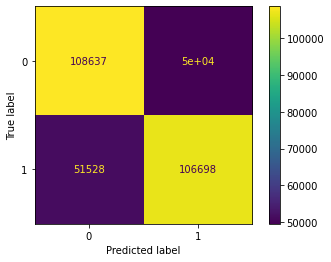

              precision    recall  f1-score   support

           0       0.68      0.69      0.68    158226
           1       0.68      0.67      0.68    158226

    accuracy                           0.68    316452
   macro avg       0.68      0.68      0.68    316452
weighted avg       0.68      0.68      0.68    316452


# ====================


Métricas de avaliação de teste:
[[46628 21184]
 [ 1993  3998]]


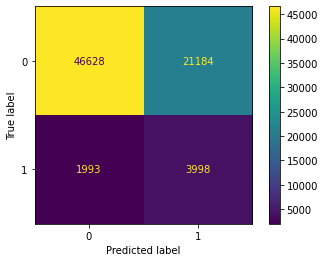

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     67812
           1       0.16      0.67      0.26      5991

    accuracy                           0.69     73803
   macro avg       0.56      0.68      0.53     73803
weighted avg       0.89      0.69      0.76     73803



In [125]:
# ================================================================

rlog = LogisticRegression(random_state=42, max_iter=10000).fit(X_train_ss, y_res)

# ================================================================

print("\nMétricas de avaliação de treino:")

y_pred_train = rlog.predict(X_train_ss)

print(confusion_matrix(y_res, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_res, y_pred_train)
plt.show()

print(classification_report(y_res, y_pred_train))

# ================================================================

print("\n# ====================\n")

print("\nMétricas de avaliação de teste:")

y_pred_test = rlog.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))


## KNN


Métricas de avaliação de treino:
[[135862  22364]
 [     0 158226]]


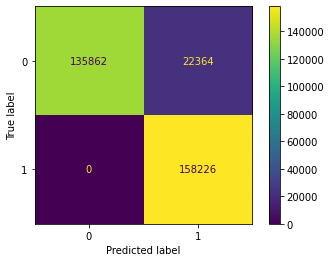

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    158226
           1       0.88      1.00      0.93    158226

    accuracy                           0.93    316452
   macro avg       0.94      0.93      0.93    316452
weighted avg       0.94      0.93      0.93    316452


# ====================


Métricas de avaliação de teste:
[[54110 13702]
 [ 4333  1658]]


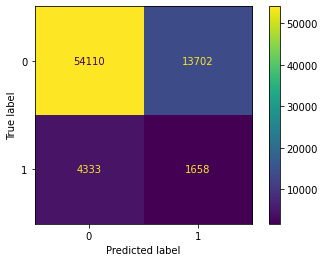

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     67812
           1       0.11      0.28      0.16      5991

    accuracy                           0.76     73803
   macro avg       0.52      0.54      0.51     73803
weighted avg       0.86      0.76      0.80     73803



In [130]:
# ================================================================

knn = KNeighborsClassifier().fit(X_train_ss, y_res)

# ================================================================

print("\nMétricas de avaliação de treino:")

y_pred_train = knn.predict(X_train_ss)

print(confusion_matrix(y_res, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_res, y_pred_train)
plt.show()

print(classification_report(y_res, y_pred_train))

print("\n# ====================\n")

# ================================================================

print("\nMétricas de avaliação de teste:")

y_pred_test = knn.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))


## Random Forest


Métricas de avaliação de treino:
[[158226      0]
 [     0 158226]]


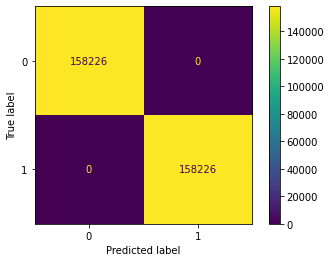

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158226
           1       1.00      1.00      1.00    158226

    accuracy                           1.00    316452
   macro avg       1.00      1.00      1.00    316452
weighted avg       1.00      1.00      1.00    316452


# ====================


Métricas de avaliação de teste:
[[67743    69]
 [ 5931    60]]


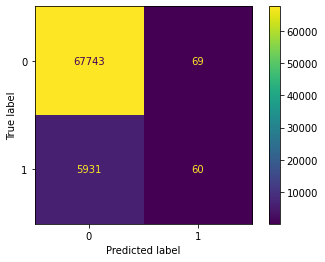

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     67812
           1       0.47      0.01      0.02      5991

    accuracy                           0.92     73803
   macro avg       0.69      0.50      0.49     73803
weighted avg       0.88      0.92      0.88     73803



In [132]:
# ================================================================

rf = RandomForestClassifier(random_state=42, class_weight='balanced').fit(X_train_ss, y_res)

# ================================================================

print("\nMétricas de avaliação de treino:")

y_pred_train = rf.predict(X_train_ss)

print(confusion_matrix(y_res, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_res, y_pred_train)
plt.show()

print(classification_report(y_res, y_pred_train))

print("\n# ====================\n")

# ================================================================

print("\nMétricas de avaliação de teste:")

y_pred_test = rf.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

## XGBoost


Métricas de avaliação de treino:
[[120827  37399]
 [ 28818 129408]]


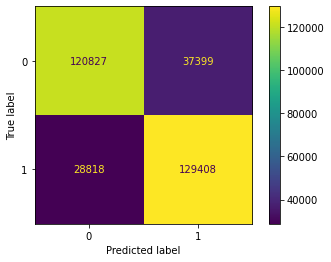

              precision    recall  f1-score   support

           0       0.81      0.76      0.78    158226
           1       0.78      0.82      0.80    158226

    accuracy                           0.79    316452
   macro avg       0.79      0.79      0.79    316452
weighted avg       0.79      0.79      0.79    316452


# ====================


Métricas de avaliação de teste:
[[50878 16934]
 [ 2493  3498]]


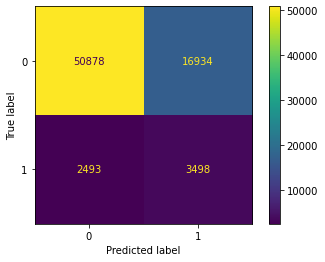

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     67812
           1       0.17      0.58      0.26      5991

    accuracy                           0.74     73803
   macro avg       0.56      0.67      0.55     73803
weighted avg       0.89      0.74      0.79     73803



In [133]:
# ================================================================

xboost = XGBClassifier(random_state=42).fit(X_train_ss, y_res)

# ================================================================

print("\nMétricas de avaliação de treino:")

y_pred_train = xboost.predict(X_train_ss)

print(confusion_matrix(y_res, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_res, y_pred_train)
plt.show()

print(classification_report(y_res, y_pred_train))

print("\n# ====================\n")

# ================================================================

print("\nMétricas de avaliação de teste:")

y_pred_test = xboost.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

## Random Forest + PCA

Aplicando o PCA para reduzir a dimensionalidade.

In [139]:
pipe_pca = Pipeline([("pca", PCA(n_components=2)),
                     ("rf", RandomForestClassifier(random_state=42, class_weight='balanced'))])


Métricas de avaliação de treino:
[[156938   1288]
 [ 26968 131258]]


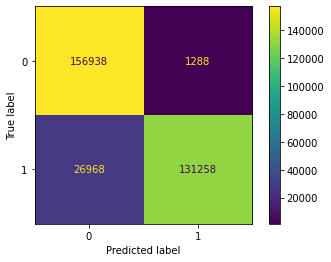

              precision    recall  f1-score   support

           0       0.85      0.99      0.92    158226
           1       0.99      0.83      0.90    158226

    accuracy                           0.91    316452
   macro avg       0.92      0.91      0.91    316452
weighted avg       0.92      0.91      0.91    316452


Métricas de avaliação de teste:
[[65203  2609]
 [ 5678   313]]


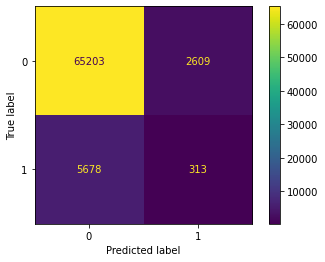

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     67812
           1       0.11      0.05      0.07      5991

    accuracy                           0.89     73803
   macro avg       0.51      0.51      0.51     73803
weighted avg       0.85      0.89      0.87     73803



In [144]:
pipe_pca.fit(X_train_ss, y_res)

metricas_classificacao2(pipe_pca, X_train_ss, X_test_ss, y_res, y_test)

Melhorou um pouco, mas os resultados ainda estão muito ruins.

## Utilizando a otimização de parâmetros - RandomSearch

Optamos por utilizar o RandomSearch, pois é otimizador de parâmetros com menor custo operacional, frente ao GridSearch e ao BayesSearch

In [ ]:
# pipe = Pipeline([("rf", RandomForestClassifier(random_state=42, class_weight='balanced'))])
# #xboost = XGBClassifier(random_state=42).fit(X_train_ss, y_res)

# params_ditro_rf = {"dt__criterion" : ["gini", "entropy"],
#                    "dt__splitter" : ["best", "random"],
#                    "dt__min_impurity_decrease" : scipy.stats.uniform(0, 1)} 

# splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid_rf_random = RandomizedSearchCV(estimator=pipe,
#                                      n_iter=100,
#                                      param_distributions=params_ditro_dt,
#                                      scoring="f1_weighted",
#                                      cv=splitter,
#                                      verbose=10)

In [147]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

In [148]:
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600,
#                     objective='binary:logistic', silent=True, nthread=1)

In [151]:
# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_ss,y_res), verbose=3, random_state=1001 )

# random_search.fit(X_train_ss, y_res)

In [ ]:
#random_search.best_params_

In [ ]:
#random_search.best_score_

In [ ]:
#metricas_classificacao2(random_search, X_train_ss, X_test_ss, y_res, y_test)

<br>

# Aplicação do modelo escolhido na base de teste

## Ajustando a base de teste conforme realizado na base de treino

In [207]:
# Carregando a base de teste
teste = 'application_test_student.csv'
df_teste = carrega_dataset(arquivo=teste, index_col=0)

In [208]:
# Fazendo a exclusão das colunas
df_teste.drop(labels = col_excluidas_dados_faltantes, inplace=True, axis=1)
df_teste.drop(labels = 'CODE_GENDER', inplace=True, axis=1)

In [211]:
# Preenchendo dados faltantes categóricos
df_teste_cat = df_teste.select_dtypes(exclude=np.number)
df_teste_cat[:] = simpleImputer_cat.transform(df_teste_cat)

In [212]:
# Preenchendo dados faltantes numéricos
df_teste_num = df_teste.select_dtypes(include=np.number)
df_teste_num[:] = simpleImputer_num.transform(df_teste_num)

# União das duas bases de treino
df_teste_transformada = pd.concat([df_teste_cat, df_teste_num], axis=1)

In [213]:
# Fazendo o OneHotEncoder nas colunas categóricas
OH_cols_df_teste = pd.DataFrame(OH_encoder.transform(df_teste_transformada[object_cols]))
OH_cols_df_teste.index = df_teste_transformada.index

# Montando dataframe apenas com as colunas numéricas
num_X_df_teste = df_teste_transformada.drop(object_cols, axis=1)

# Concatenando colunas categóricas e numéricas
OH_X_df_teste = pd.concat([num_X_df_teste, OH_cols_df_teste], axis=1)

In [214]:
# Aplicando a padronização
df_teste_ss = ss.transform(OH_X_df_teste)

C:\Users\maeba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [215]:
# Aplicando o modelo treinado
y_pred_df_teste = xboost.predict(df_teste_ss)

In [216]:
# Montando dataframe de entrega
df_entrega = pd.DataFrame(columns=['SK_ID_CURR', 'TARGET_PRED'])

In [217]:
df_entrega['SK_ID_CURR'] = df_teste.index

In [218]:
df_entrega['TARGET_PRED'] = y_pred_df_teste

In [219]:
df_entrega.set_index('SK_ID_CURR')

,TARGET_PRED
SK_ID_CURR,
149741,1
363290,0
436006,1
377703,0
188624,1
...,...
102817,0
343961,0
427828,0


In [220]:
df_entrega.to_csv('Projeto_entrega_ML.csv', sep=';', encoding='utf-8', index=False)

<br>

# Conclusão

**Dados**<br>
O primeiro desafio do projeto foi descobrir como trabalhar com um grande número de colunas, pois análises iniciais como info, describe ou de correlação são difíceis de interpretar quando cruzamos muitas informações.<br>
Da mesma forma as análises gráficas tornam-se muito custosas computacionalmente ou não é possível interpretá-las. Para uma análise inicial um caminho escolhido é explorar os dados para então escolher poucas variáveis e apresentá-las graficamente.<br><br>
**Limpeza, transformação e seleção de features**<br>
A estratégia utilizada para a limpeza foi a exclusão das variáveis que possuíam mais de 40% de dados faltantes. A decisão do limite foi considerando que preencher mais do que 40% significaria que a coluna teria mais dados adicionados do que dados reais.<br>
Fizemos o preenchimento das colunas categóricas restantes com a palavra “unknown” e das colunas numéricas com a média. E transformamos as colunas categóricas através do OneHotEncoder.<br>
Sobre os outliers, fizemos uma tentativa inicial de cálculo do z-score que não foi possível rodar devido ao poder computacional disponível. Uma segunda análise levou em consideração os quartis e chegamos a conclusão que o número de linhas que seriam excluídas caso optássemos por remover todas as linhas que continham outliers indicados pelo IQR seria muito grande, podendo prejudicar a análise. Cogitamos excluir as linhas que possuíssem mais do que 8 outliers, mas decidimos não excluir outliers num primeiro momento, devido a dificuldade de visualização dos mesmos e falta de conhecimento aprofundado da área de crédito.<br><br>
**Modelos**<br>
Target: 
- Classe 1 (clientes que atrasam o pagamento); 
- Classe 0 (demais casos – provavelmente pagariam em dia).
Dessa forma optamos por melhorar nosso recall da classe 1 para que o modelo classifique corretamente as pessoas e assim não deixemos passar aqueles que não pagariam e, portanto, gerariam prejuízo à empresa.
Sendo um problema de classificação escolhemos alguns algoritmos: regressão logística, KNN, Random Forest e XBoost. 
A regressão logística foi aplicada como baseline e inicialmente fizemos com a base completa sem o balanceamento de classes:
Recall:
- Classe 0: 100%;
- Classe 1: 1%;
Acurácia: 92%.
Depois excluímos as colunas com muitos dados faltantes, mas o resultado não mudou.
A regressão logística com os dados balanceados apresentou um resultado melhor considerando que a classe 1 é importante para a nossa decisão, mas o recall ainda poderia ser melhorado.
Recall:
- Classe 0: 69%;
- Classe 1: 67%;
Acurácia: 69%.
O KNN demandou muito poder computacional devido ao número de variáveis e não apresentou resultado satisfatório. O recall da classe 1 foi muito baixo, embora a acurácia tenha melhorado. O modelo é muito sensível a atributos irrelevantes e provavelmente melhoria com a remoção dos mesmos.
Recall:
- Classe 0: 80%;
- Classe 1: 28%;
Acurácia: 76%.

Utilizando o modelo Random Forest tivemos a ocorrência de overfitting. Dessa forma recusaríamos a maioria dos pedidos de crédito e teríamos menos prejuízo, mas a empresa também teria menos lucro ao recusar bons pagadores.
Recall:
- Classe 0: 100%;
- Classe 1: 1%;
Acurácia: 92%.

Já com o modelo de XGBoost, tivemos nossas melhores métricas de recall. Melhoramos nossa taxa de acerto para os bons pagadores e também diminuímos nossa taxa de erro para os bons pagadores, mas passaríamos a conceder mais crédito aos maus pagadores.
Recall:
- Classe 0: 76%;
- Classe 1: 82%;
Acurácia: 79%.

Dessa forma teríamos que avaliar a estratégia da empresa em minimizar os prejuízos (Random Forest) ou aumentar o número de clientes emprestando mais dinheiro (XGBoost).
Para a entrega escolhemos o XBoost.

Abaixo os pontos relevantes e de melhoria:
- A base precisaria estar “limpa” evitando interferência no modelo;
- Balanceamento de dados é um ponto fundamental;
- Aplicação de Grid Search para escolher os melhores parâmetros;
- Seleção de features para evitar variáveis desnecessárias ou com muita correlação;
- Uso de pipeline para facilitar a aplicação no modelo de teste;
- Uso de pipeline para testar outros algoritmos;
- Utilizar bases auxiliares para complementar os dados.
